# Tournament simulation using PyStan

In this notebook, I build a simple Bayesian model to predict the outcome of the tournament. Since the bracket deadline is soon, I don't have time to add comments and there is plenty to clean up and improve. Comments are welcome!

Main idea: assign score $\alpha_i$ to each team, predict $\sqrt{\Delta}$ where $\Delta$ is the difference in scores using $\sqrt{\Delta} \approx \alpha_i - \alpha_j + h$ where $h$ is the home-field advantage.

There is no validation, so use at your own risk, though the predictions do lack creativity so it must have captured some common trends.

In [1]:
import random
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import pystan as ps

In [2]:
first_season = 2010

In [3]:
def convert_Wloc(loc):
    if loc == "H":
        return 1
    if loc == "A":
        return -1
    return 0

In [4]:
rs_df = pd.read_csv("ncaam-data/RegularSeasonCompactResults.csv")
t_df = pd.read_csv("ncaam-data/TourneyCompactResults.csv")

games = pd.concat((rs_df, t_df))
teams = pd.read_csv("ncaam-data/Teams.csv")
seeds = pd.read_csv("ncaam-data/TourneySeeds.csv")
slots = pd.read_csv("ncaam-data/TourneySlots.csv")


tid_to_id = { team: idx for idx, team in enumerate(teams["Team_Id"].factorize()[1]) }
id_to_tid = { idx: team for idx, team in enumerate(teams["Team_Id"].factorize()[1]) }

games["win_id"] = games.apply(lambda x: tid_to_id[x.Wteam], 1)
games["los_id"] = games.apply(lambda x: tid_to_id[x.Lteam], 1)
games["athome"] = games.apply(lambda x: convert_Wloc(x.Wloc), 1)

games = games[games["Season"] >= first_season]

games["t"] = games.Season - first_season
games["dscore"] = np.sqrt(games.Wscore - games.Lscore)

In [5]:
games.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,win_id,los_id,athome,t,dscore
108122,2010,7,1143,75,1293,70,H,0,42,192,1,0,2.236068
108123,2010,7,1314,88,1198,72,H,0,213,97,1,0,4.000000
108124,2010,7,1326,100,1108,60,H,0,225,7,1,0,6.324555
108125,2010,7,1393,75,1107,43,H,0,292,6,1,0,5.656854
108126,2010,9,1143,95,1178,61,H,0,42,77,1,0,5.830952


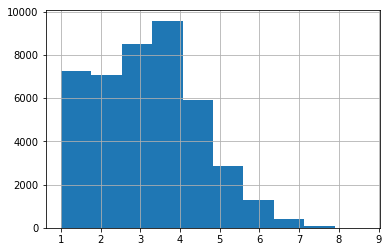

In [6]:
games.dscore.hist()

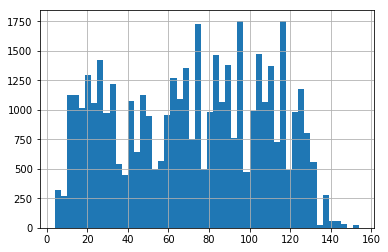

In [7]:
games.Daynum.hist(bins=50)

# Simple Stan model

In [8]:
stan_code = """
data {
    int<lower=0> nteams; // number of teams
    int<lower=1> nseasons; // number of seasons
    int<lower=0> N; // number of observations
    
    real dscore[N]; // Outcome
    int tid[N]; // Team
    int oid[N]; // Opponent
    int location[N]; // location of game
    int season[N]; // Season of game
}
transformed data {}
parameters {
    real home;
    real team[nteams, nseasons];
    
    // evolution of teams
    real<lower=0> sigma_team0;
    real<lower=0> sigma_teamd;
    
    // variance for home game advantage
    real<lower=0, upper=5> sigma_home;
    
    // variance in outcome
    real<lower=0, upper=5> sigma_score;
}
transformed parameters {
    vector[N] xb;
    for(i in 1:N) {
        xb[i] = home * location[i] + team[tid[i], season[i]] - team[oid[i], season[i]];
    }
}
model {
    home ~ normal(0.1, sigma_home);
    
    for(t in 1:nteams) {
        team[t, 1] ~ normal(0.0, sigma_team0);
        for(s in 2:nseasons) {
            team[t, s] ~ normal(team[t, s-1], sigma_teamd); // for now independent between seasons
        }
    }
    
    // outcome
    dscore ~ normal(xb, sigma_score);
}
generated quantities {
}
"""


In [9]:
stan_data = {
    "nteams": len(id_to_tid),
    "nseasons": max(games.t)+1,
    "N": len(games),
    "dscore": games.dscore,
    "tid": games.win_id+1,
    "oid": games.los_id+1,
    "season": games.t + 1,
    "location": games.athome
}

print(f"Number of games: {len(games)}")

Number of games: 43028


In [10]:
stan_iters = 500
stan_fit = ps.stan(model_code=stan_code, data=stan_data, iter=stan_iters, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_165a291e814ee6ab964b70cfa8acd4ed NOW.


In [11]:
stan_params = stan_fit.extract()

team_scores = stan_params["team"]
sigma_score = stan_params["sigma_score"]

def tid_to_name(tid):
    return teams[teams.Team_Id == tid].iloc[0].Team_Name

def id_to_name(idx):
    return tid_to_name(id_to_tid[idx])

In [14]:
tid_to_name(1448)

'Wake Forest'

### Inspect the 10 best and 5 worst teams as sanity check.

In [16]:
mean_team_scores = team_scores.mean(axis=0)
tourny_teams = seeds[seeds.Season == 2017].Team.unique()
tourny_teams_ids = [tid_to_id[t] for t in tourny_teams]

# show top 10 teams
qualified_teams = sorted(list(zip(mean_team_scores[tourny_teams_ids, -1], 
                                  [(id_to_name(idx), idx) for idx in tourny_teams_ids])))

qualified_teams[-10:]

[(4.0768819502527291, ('Oregon', 231)),
 (4.0970002376384107, ('Florida', 95)),
 (4.1122340329343352, ('Duke', 80)),
 (4.1183369993284389, ('West Virginia', 351)),
 (4.2562590612210416, ('Louisville', 156)),
 (4.5722047287169856, ('Gonzaga', 110)),
 (4.5908491353565122, ('Kansas', 141)),
 (4.601773206455384, ('North Carolina', 213)),
 (4.6117008965689639, ('Kentucky', 145)),
 (4.9001365358175653, ('Villanova', 336))]

In [17]:
qualified_teams[:5]

[(-0.72942444353710778, ("Mt St Mary's", 190)),
 (-0.457477967726653, ('New Orleans', 208)),
 (-0.39542343499332833, ('UC Davis', 312)),
 (-0.36312374011438514, ('Jacksonville St', 139)),
 (-0.14225913461711642, ('TX Southern', 310))]

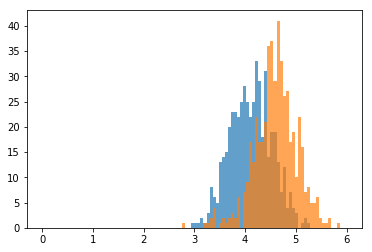

In [18]:
f, ax = plt.subplots(1, 1)
_ = ax.hist(team_scores[:, 80, -1], bins=100, range=(0, 6), alpha=0.7)
_ = ax.hist(team_scores[:, 213, -1], bins=100, range=(0,6), alpha=0.7)

# Tournament simulation

In [19]:
tournament = slots[slots.Season == 2017][["Slot", "Strongseed", "Weakseed"]].set_index("Slot").to_dict("index")
# purge initial playoffs (manually :()

tournament = {k: (v["Strongseed"], v["Weakseed"]) for k, v in tournament.items() if v["Strongseed"][-1] != "a"}

In [20]:
initial = seeds[seeds.Season == 2017][["Seed", "Team"]].set_index("Seed").to_dict("index")

initial = {k: v["Team"] for k, v in initial.items() if k[-1] not in ["a", "b"]}

initial["W11"] = 1425
initial["W16"] = 1291
initial["Y16"] = 1413
initial["Z11"] = 1243

In [21]:
tid_to_name(1243)

'Kansas St'

In [22]:
def simulate_game(A, B, trace):
    """
    Simulates game between teams A and B
    
    Returns: winner, loser, margin
    """
    idA = tid_to_id[A]
    idB = tid_to_id[B]
    
    # find team coefficients
    alpha_a = team_scores[trace, idA, -1]
    alpha_b = team_scores[trace, idB, -1]
    
    sqrt_score = random.gauss(alpha_a - alpha_b, sigma_score[trace])
    
    # return result
    if sqrt_score >= 0:
        return A, B, sqrt_score**2
    
    return B, A, sqrt_score**2

Checking whether simulations make sense. Win percentage seem a little conservative between number 1 and number 16 seed, which is normal for this type of model. The predicted scores are clearly over-dispersed; that is due to the square root. However, it shouldn't influence the simulations too much.

In [23]:
len(teams)

364

In [24]:
name_to_tid = {id_to_name(idx): id_to_tid[idx] for idx in range(len(teams))}

Simulating Michigan vs Louisville
Michigan wins 31.422222222222224%


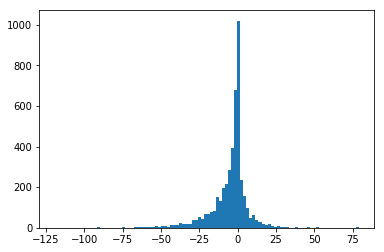

In [25]:
team_a = name_to_tid["Michigan"]
team_b = name_to_tid["Louisville"]
tid_to_name(team_a), tid_to_name(team_b)

raw_games = []
for _ in range(10):
    raw_games += [simulate_game(team_a, team_b, t) for t in range(50, stan_iters)]
    
final_scores = [(2*(a==team_a)-1) * score for a, b, score in raw_games]

print(f"Simulating {tid_to_name(team_a)} vs {tid_to_name(team_b)}")
a_win_perc = len([s for s in final_scores if s > 0]) / len(final_scores)
print(f"{tid_to_name(team_a)} wins {100*a_win_perc}%")

f = plt.hist(final_scores, bins=100, label="Final score")

In [26]:
def simulate_tournament(trace):
    results = {seed: team for seed, team in initial.items()}
    games = []
    
    for match, (teamA, teamB) in tournament.items():
        winner, loser, score = simulate_game(results[teamA], results[teamB], trace)
        results[match] = winner
        # round of game
        r = match[1]
        games.append((winner, loser, score, r))
    
    # clean initial seeds
    clean_results = {r: tid_to_name(winner)
            for r, winner in results.items() if r[0] == "R"}
    
    return clean_results, games

## Simulate a single tournament

In [27]:
results, games = simulate_tournament(101)

for tidA, tidB, score, rnd in games:
    print("Round {3}: {0:<20} def.    {1:<20}  {2}".format(tid_to_name(tidA), tid_to_name(tidB), int(score), rnd))

Round 1: Villanova            def.    Mt St Mary's          63
Round 1: Duke                 def.    Troy                  41
Round 1: Baylor               def.    New Mexico St         18
Round 1: Florida              def.    ETSU                  0
Round 1: Virginia             def.    UNC Wilmington        1
Round 1: USC                  def.    SMU                   0
Round 1: South Carolina       def.    Marquette             25
Round 1: Wisconsin            def.    Virginia Tech         0
Round 1: Gonzaga              def.    S Dakota St           1
Round 1: North Dakota         def.    Arizona               0
Round 1: Florida St           def.    FL Gulf Coast         17
Round 1: West Virginia        def.    Bucknell              27
Round 1: Notre Dame           def.    Princeton             3
Round 1: Maryland             def.    Xavier                0
Round 1: VA Commonwealth      def.    St Mary's CA          5
Round 1: Vanderbilt           def.    Northwestern          0
Ro

# Simulate many tournaments

In [28]:
round_counters = defaultdict(Counter)

In [29]:
for _ in range(10000):
    trace = random.randint(50, 499)
    sim, _ = simulate_tournament(trace)
    for rnd, team in sim.items():
        round_counters[rnd].update([team]) 

In [30]:
def perc_counter(cntr):
    total = sum(cntr.values())
    return sorted([(team, cnt/total) for team, cnt in cntr.items()], key=lambda x: -x[1])

In [31]:
percentages = {rnd: perc_counter(c) for rnd, c in round_counters.items()}

for rnd, teams in percentages.items():
    print("Round: {}".format(rnd))
    for team, perc in teams:
        print("{:>3.1f}% : {}".format(100*perc, team))
    print("-"*10)

Round: R1W1
98.8% : Villanova
1.2% : Mt St Mary's
----------
Round: R1W2
95.0% : Duke
5.0% : Troy
----------
Round: R1W3
83.6% : Baylor
16.4% : New Mexico St
----------
Round: R1W4
83.0% : Florida
17.0% : ETSU
----------
Round: R1W5
74.5% : Virginia
25.6% : UNC Wilmington
----------
Round: R1W6
69.0% : SMU
31.0% : USC
----------
Round: R1W7
53.9% : South Carolina
46.1% : Marquette
----------
Round: R1W8
65.1% : Wisconsin
34.9% : Virginia Tech
----------
Round: R1X1
95.8% : Gonzaga
4.2% : S Dakota St
----------
Round: R1X2
94.7% : Arizona
5.3% : North Dakota
----------
Round: R1X3
85.8% : Florida St
14.2% : FL Gulf Coast
----------
Round: R1X4
86.9% : West Virginia
13.1% : Bucknell
----------
Round: R1X5
71.7% : Notre Dame
28.3% : Princeton
----------
Round: R1X6
50.8% : Xavier
49.2% : Maryland
----------
Round: R1X7
60.6% : St Mary's CA
39.4% : VA Commonwealth
----------
Round: R1X8
52.5% : Vanderbilt
47.5% : Northwestern
----------
Round: R1Y1
97.5% : Kansas
2.5% : UC Davis
----------

That is, the model believes Villanova has a 12.8% probability of winning the tournament!